# Phantom data

## Check the Phantom image

In [1]:
from pymatreader import read_mat

phantom_img = read_mat('phantom/phantom_Img.mat')
phantom_img.keys()

dict_keys(['img'])

In [2]:
import numpy as np

phantom_img = np.array(phantom_img['img'])
phantom_img.shape

(374, 128, 10)

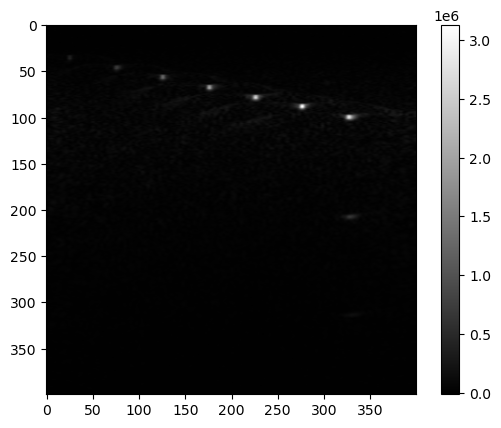

In [3]:
import matplotlib.pyplot as plt

import scipy.ndimage

def scan_convertion(image, target_size):
    return scipy.ndimage.zoom(image, (target_size[0] / image.shape[0], target_size[1] / image.shape[1]))
converted_phantom_img = scan_convertion(phantom_img[:,:,0], (400, 400))

plt.imshow(converted_phantom_img, cmap='gray')
plt.colorbar()
plt.show()

## Phantom rfdata processing

### Read phantom rfdata

In [4]:
phantom_rfdata = read_mat('phantom/phantom_rfdata.mat')
phantom_rfdata.keys()

dict_keys(['rfdata'])

In [5]:
phantom_rfdata = np.array(phantom_rfdata['rfdata'])
phantom_rfdata.shape

(2176, 128, 100)

In [6]:
phantom_rfdata[:,:,0].shape

(2176, 128)

### Calculate the distance from probe(element) to pixel

In [7]:
element = 128
col_pixel = 128
row_pixel = 2048 #(> 1580)

In [8]:
col_spacing = 0.3e-3 # 0.3 mm
row_spacing = 0.04/row_pixel

In [9]:
distance = np.zeros((element, row_pixel, col_pixel))
distance.shape # 채널 == element 순서, 0번 채널은 0번 element의 각 픽셀까지의 거리 [element][row][col]

(128, 2048, 128)

In [10]:
# 각 element 직선 상 밑에 있는 픽셀들의 거리 계산
for ele in range(element):
    for row in range(row_pixel):
        if row == 0:
            distance[ele][row][ele] = row_spacing / 2
        else:
            distance[ele][row][ele] = distance[ele][row-1][ele] + row_spacing

In [11]:
# element에서 각 픽셀까지의 거리 계산
for ele in range(element):
    for row in range(row_pixel):
        for col in range(ele+1, col_pixel):
            distance[ele][row][col] = np.sqrt((np.abs(ele - col) * col_spacing)**2 + distance[ele][row][ele]**2)
        for col in range(ele-1, -1, -1):
            distance[ele][row][col] = np.sqrt((np.abs(ele - col) * col_spacing)**2 + distance[ele][row][ele]**2)

In [12]:
distance

array([[[9.76562500e-06, 3.00158904e-04, 6.00079468e-04, ...,
         3.75000013e-02, 3.78000013e-02, 3.81000013e-02],
        [2.92968750e-05, 3.01427117e-04, 6.00714830e-04, ...,
         3.75000114e-02, 3.78000114e-02, 3.81000113e-02],
        [4.88281250e-05, 3.03947669e-04, 6.01983543e-04, ...,
         3.75000318e-02, 3.78000315e-02, 3.81000313e-02],
        ...,
        [3.99511719e-02, 3.99522982e-02, 3.99556771e-02, ...,
         5.47936687e-02, 5.49994194e-02, 5.52060335e-02],
        [3.99707031e-02, 3.99718289e-02, 3.99752062e-02, ...,
         5.48079110e-02, 5.50136084e-02, 5.52201694e-02],
        [3.99902344e-02, 3.99913596e-02, 3.99947352e-02, ...,
         5.48221565e-02, 5.50278007e-02, 5.52343086e-02]],

       [[3.00158904e-04, 9.76562500e-06, 3.00158904e-04, ...,
         3.72000013e-02, 3.75000013e-02, 3.78000013e-02],
        [3.01427117e-04, 2.92968750e-05, 3.01427117e-04, ...,
         3.72000115e-02, 3.75000114e-02, 3.78000114e-02],
        [3.03947669e-04, 

In [13]:
distance[0][0][127]

0.038100001251541074

### Delay and Sum

In [24]:
sound_speed_p = 1450 # m/s
center_freq = 7.6e6 # Hz
sampling_rate = 4.1
sampling_freq = center_freq * sampling_rate # 31.16 MHz

In [25]:
delay = np.zeros((element, row_pixel, col_pixel))

In [230]:
n = 30
th = np.deg2rad(n)
np.cos(th)
# max_l = np.sqrt(3) / np.cos(th)
# max_l
mu, sigma = 0, 1
s = np.random.normal(mu, sigma, 512)
s.sort()
s = s[s > 0][::-1]
# s

In [231]:

for ele in range(element):
    for row in range(row_pixel):
        d = (row_spacing / 2) + (row * row_spacing) # distance from element to pixel_row
        if th == 180:
            max_l = np.inf
        else:
            max_l = d / np.cos(th/2)
        for col in range(col_pixel):
            l = distance[ele][row][col] # distance from element to pixel
            if max_l < l:
                delay[ele][row][col] = -1
            else:
                delay[ele][row][col] = ((d + l) / sound_speed_p) * sampling_freq

In [232]:
delay

array([[[ 4.19719828e-01, -1.00000000e+00, -1.00000000e+00, ...,
         -1.00000000e+00, -1.00000000e+00, -1.00000000e+00],
        [ 1.25915948e+00, -1.00000000e+00, -1.00000000e+00, ...,
         -1.00000000e+00, -1.00000000e+00, -1.00000000e+00],
        [ 2.09859914e+00, -1.00000000e+00, -1.00000000e+00, ...,
         -1.00000000e+00, -1.00000000e+00, -1.00000000e+00],
        ...,
        [ 1.71707381e+03,  1.71709802e+03,  1.71717063e+03, ...,
         -1.00000000e+00, -1.00000000e+00, -1.00000000e+00],
        [ 1.71791325e+03,  1.71793745e+03,  1.71801002e+03, ...,
         -1.00000000e+00, -1.00000000e+00, -1.00000000e+00],
        [ 1.71875269e+03,  1.71877688e+03,  1.71884942e+03, ...,
         -1.00000000e+00, -1.00000000e+00, -1.00000000e+00]],

       [[-1.00000000e+00,  4.19719828e-01, -1.00000000e+00, ...,
         -1.00000000e+00, -1.00000000e+00, -1.00000000e+00],
        [-1.00000000e+00,  1.25915948e+00, -1.00000000e+00, ...,
         -1.00000000e+00, -1.00000000e

In [233]:
delay[0][0][0], delay[0][0][1], delay[0][0][2], delay[0][0][127]

(0.41971982758620685, -1.0, -1.0, -1.0)

In [234]:
def cal_weight(p):
    i = int(p)
    f = p - i
    return (1-f, f)


In [235]:
pixel = np.zeros((row_pixel, col_pixel))
pixel.shape

(2048, 128)

In [236]:
for row in range(row_pixel):
    for col in range(col_pixel):
        s = np.random.normal(mu, sigma, 512)    # element weight
        s.sort()
        s = s[s > 0][::-1]
        for ele in range(element):
            if delay[ele][row][col] == -1:
                continue
            p = delay[ele][row][col]
            a, b = phantom_rfdata[:,:,0][int(p)][ele], phantom_rfdata[:,:,0][int(p) + 1][ele]
            a_w, b_w = cal_weight(p)
            pixel[row][col] += (a * a_w + b * b_w)*s[np.abs(ele - col)]

In [237]:
pixel

array([[-126.71689884, -192.11122692, -147.29406272, ..., -216.65378357,
        -108.81656792, -132.29482366],
       [-192.1766959 , -167.09899826, -125.47263886, ..., -155.76690347,
        -171.37899855, -133.82498657],
       [ -13.99489939,   78.94456393,   31.32599496, ...,   30.03210403,
         -79.06606133,  -24.44239963],
       ...,
       [   2.56264274,  -12.09610934,  110.38379857, ...,  -66.52022078,
        -110.09387257,  -26.06874125],
       [ -43.74114823,  -78.30948315,   11.56708564, ..., -118.94471478,
         -26.36459046,  -12.94076927],
       [ -51.02780999,  -76.87689813,  -95.72774703, ...,  -19.04800301,
          56.40992257,  -17.2225032 ]])

### Hilbert Transform

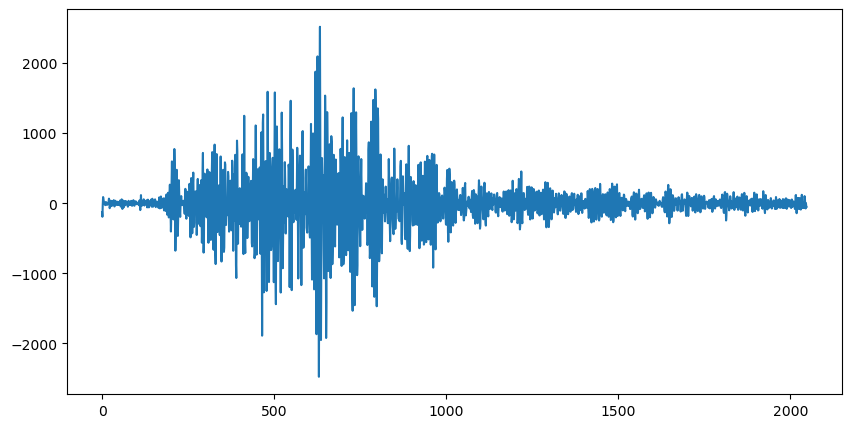

In [238]:
# before hilbert transform
plt.figure(figsize=(10, 5))
plt.plot(pixel[:,0])
plt.show()

In [239]:
from scipy.signal import hilbert

pixel_hilbert = np.abs(hilbert(pixel, axis=0))

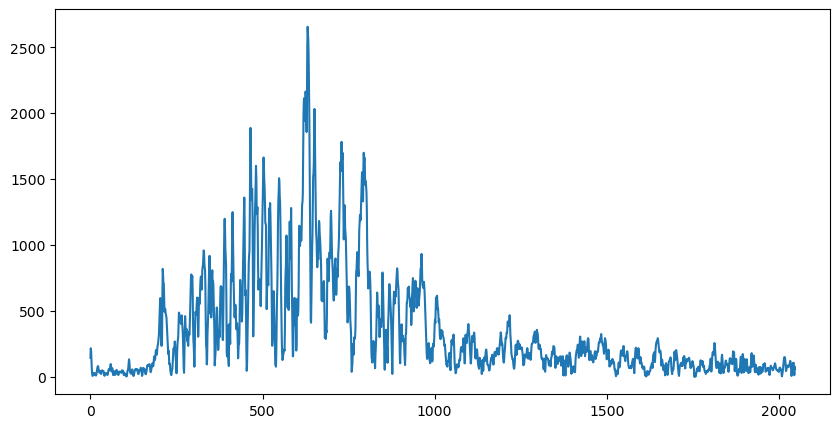

In [240]:
plt.figure(figsize=(10, 5))
plt.plot(pixel_hilbert[:,0])
plt.show()

### Log Compression

In [241]:
log_pixel_hilbert = 20 * np.log10(pixel_hilbert)

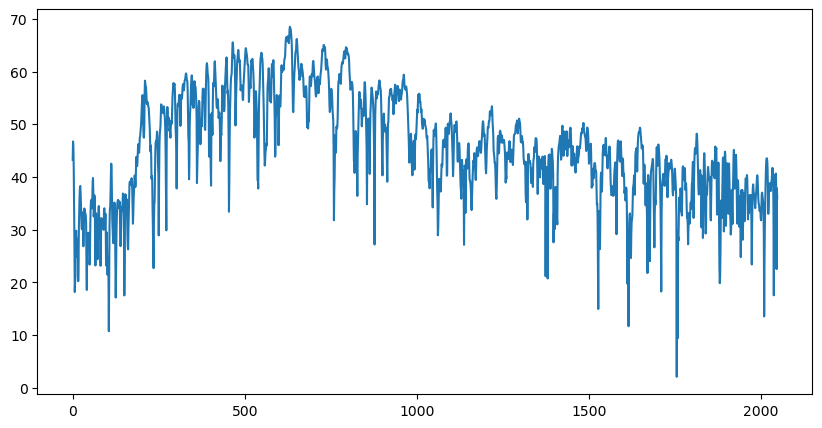

In [242]:
plt.figure(figsize=(10, 5))
plt.plot(log_pixel_hilbert[:,0])
plt.show()

### Scan Conversion

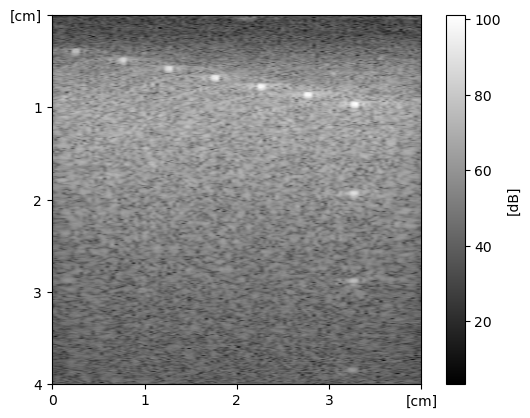

In [243]:
import scipy.ndimage

def scan_convertion(image, target_size):
    return scipy.ndimage.zoom(image, (target_size[0] / image.shape[0], target_size[1] / image.shape[1]))
# Define the target size
target_size = (400, 400)

# Perform scan conversion
scan_converted_image = scan_convertion(log_pixel_hilbert, target_size)

# Display the scan converted image
plt.imshow(scan_converted_image, cmap='gray')
plt.xticks(np.arange(0, 401, 100), labels=['0', '1', '2', '3', '[cm]'])
plt.yticks(np.arange(0, 401, 100), labels=['[cm]', '1', '2', '3', '4'])
plt.colorbar(label='[dB]')
plt.show()


### Dynamic Range Adjustment

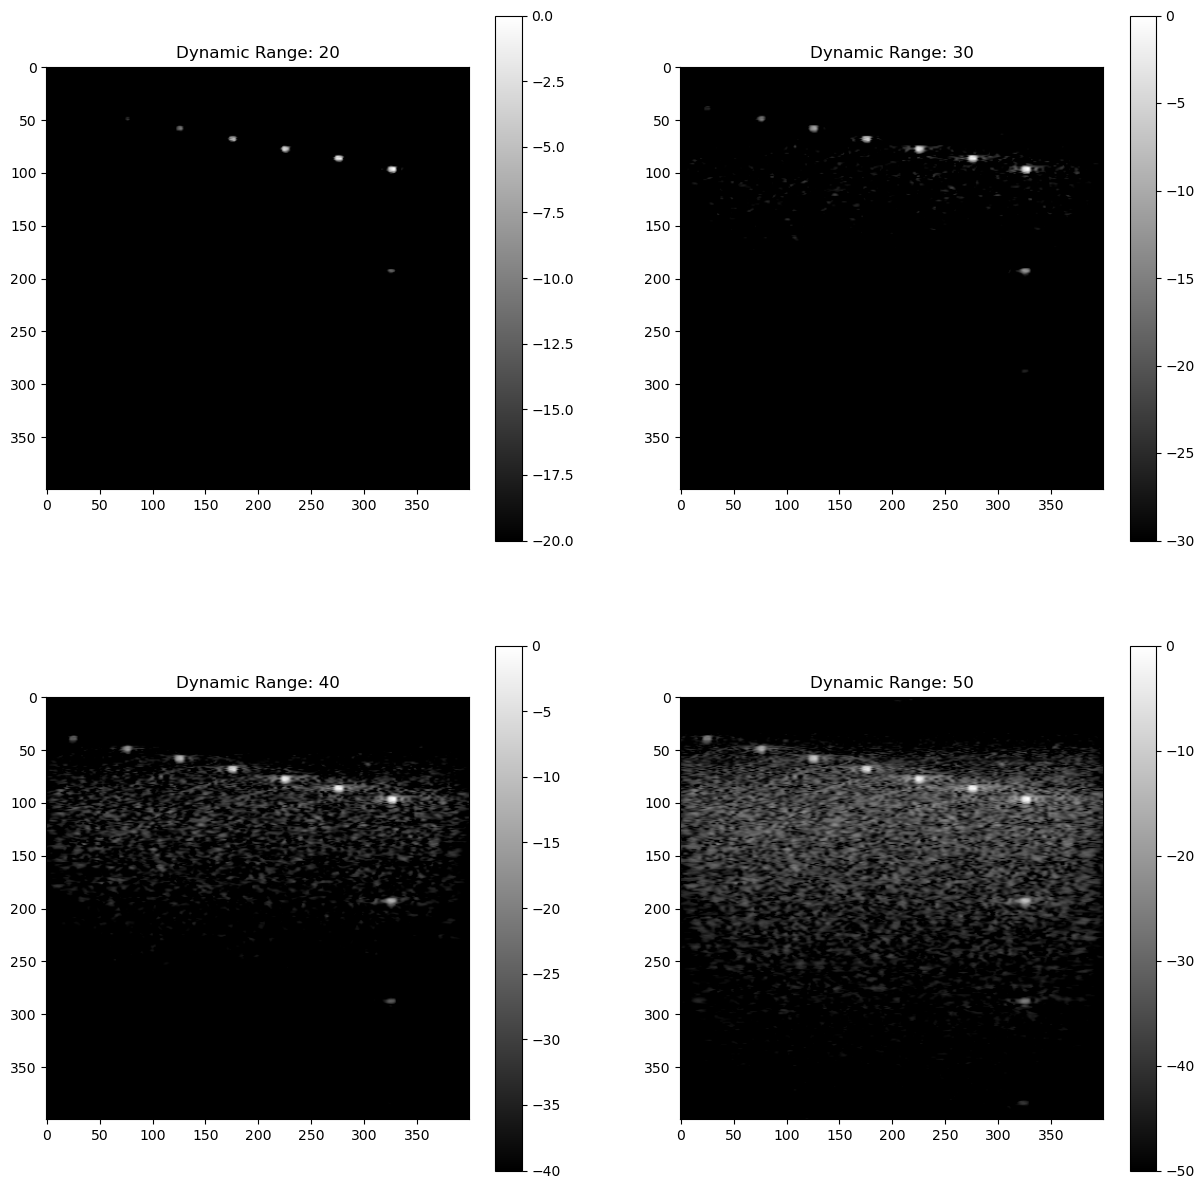

In [244]:
dynamic_range = [20, 30, 40, 50]
max_zero_img = scan_converted_image - np.max(scan_converted_image)
final_phantom_img = [np.maximum(max_zero_img, -dr) for dr in dynamic_range]

plt.figure(figsize=(15, 15))
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.imshow(final_phantom_img[i], cmap='gray')
    plt.title('Dynamic Range: ' + str(dynamic_range[i]))
    plt.colorbar()
plt.show()

# 202155642 Arm data

## Check the Arm image

In [27]:
from pymatreader import read_mat

arm_img = read_mat('202155642/arm_Img.mat')
arm_img.keys()

dict_keys(['img'])

In [28]:
import numpy as np

arm_img = np.array(arm_img['img'])
arm_img.shape

(374, 128, 10)

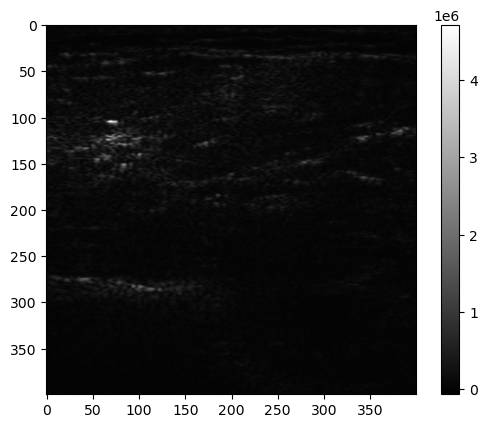

In [29]:
import matplotlib.pyplot as plt

import scipy.ndimage

def scan_convertion(image, target_size):
    return scipy.ndimage.zoom(image, (target_size[0] / image.shape[0], target_size[1] / image.shape[1]))
converted_arm_img = scan_convertion(arm_img[:,:,0], (400, 400))

plt.imshow(converted_arm_img, cmap='gray')
plt.colorbar()
plt.show()

## Arm rfdata processing

### Read arm rfdata

In [30]:
arm_rfdata = read_mat('202155642/arm_rfdata.mat')
arm_rfdata.keys()

dict_keys(['rfdata'])

In [31]:
arm_rfdata = np.array(arm_rfdata['rfdata'])
arm_rfdata.shape

(2176, 128, 100)

In [32]:
arm_rfdata[:,:,0].shape

(2176, 128)

### Calculate the distance from probe(element) to pixel

In [33]:
element = 128
col_pixel = 128
row_pixel = 2048 #(> 1580)
col_spacing = 0.3e-3 # 0.3 mm
row_spacing = 0.04/row_pixel
distance = np.zeros((element, row_pixel, col_pixel))
distance.shape # 채널 == element 순서, 0번 채널은 0번 element의 각 픽셀까지의 거리 [element][row][col]

# 각 element 직선 상 밑에 있는 픽셀들의 거리 계산
for ele in range(element):
    for row in range(row_pixel):
        if row == 0:
            distance[ele][row][ele] = row_spacing / 2
        else:
            distance[ele][row][ele] = distance[ele][row-1][ele] + row_spacing

# element에서 각 픽셀까지의 거리 계산
for ele in range(element):
    for row in range(row_pixel):
        for col in range(ele+1, col_pixel):
            distance[ele][row][col] = np.sqrt((np.abs(ele - col) * col_spacing)**2 + distance[ele][row][ele]**2)
        for col in range(ele-1, -1, -1):
            distance[ele][row][col] = np.sqrt((np.abs(ele - col) * col_spacing)**2 + distance[ele][row][ele]**2)

### Delay and Sum

In [34]:
def cal_weight(p):
    i = int(p)
    f = p - i
    return (1-f, f)

In [35]:
sound_speed_a = 1540 # m/s
center_freq = 7.6e6 # Hz
sampling_rate = 4.1
sampling_freq = center_freq * sampling_rate # 31.16 MHz

delay = np.zeros((element, row_pixel, col_pixel))

for ele in range(element):
    for row in range(row_pixel):
        d = (row_spacing / 2) + (row * row_spacing) # distance from element to pixel_row
        for col in range(col_pixel):
            l = distance[ele][row][col] # distance from element to pixel
            delay[ele][row][col] = ((d + l) / sound_speed_a) * sampling_freq

pixel = np.zeros((row_pixel, col_pixel))


for row in range(row_pixel):
    for col in range(col_pixel):
        for ele in range(element):
            p = delay[ele][row][col]
            a, b = arm_rfdata[:,:,0][int(p)][ele], arm_rfdata[:,:,0][int(p) + 1][ele]
            a_w, b_w = cal_weight(p)
            pixel[row][col] += (a * a_w + b * b_w)

### Hilbert Transform

In [36]:
from scipy.signal import hilbert

pixel_hilbert = np.abs(hilbert(pixel, axis=0))

### Log Compression

In [37]:
log_pixel_hilbert = 20 * np.log10(pixel_hilbert)

### Scan Conversion

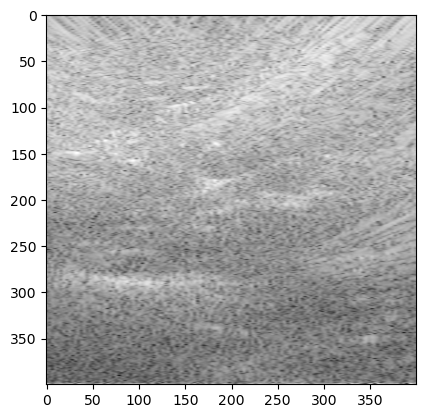

In [38]:
import scipy.ndimage

def scan_convertion(image, target_size):
    return scipy.ndimage.zoom(image, (target_size[0] / image.shape[0], target_size[1] / image.shape[1]))
# Define the target size
target_size = (400, 400)

# Perform scan conversion
scan_converted_image = scan_convertion(log_pixel_hilbert, target_size)

# Display the scan converted image
plt.imshow(scan_converted_image, cmap='gray')
plt.show()


### Dynamic Range Adjustment

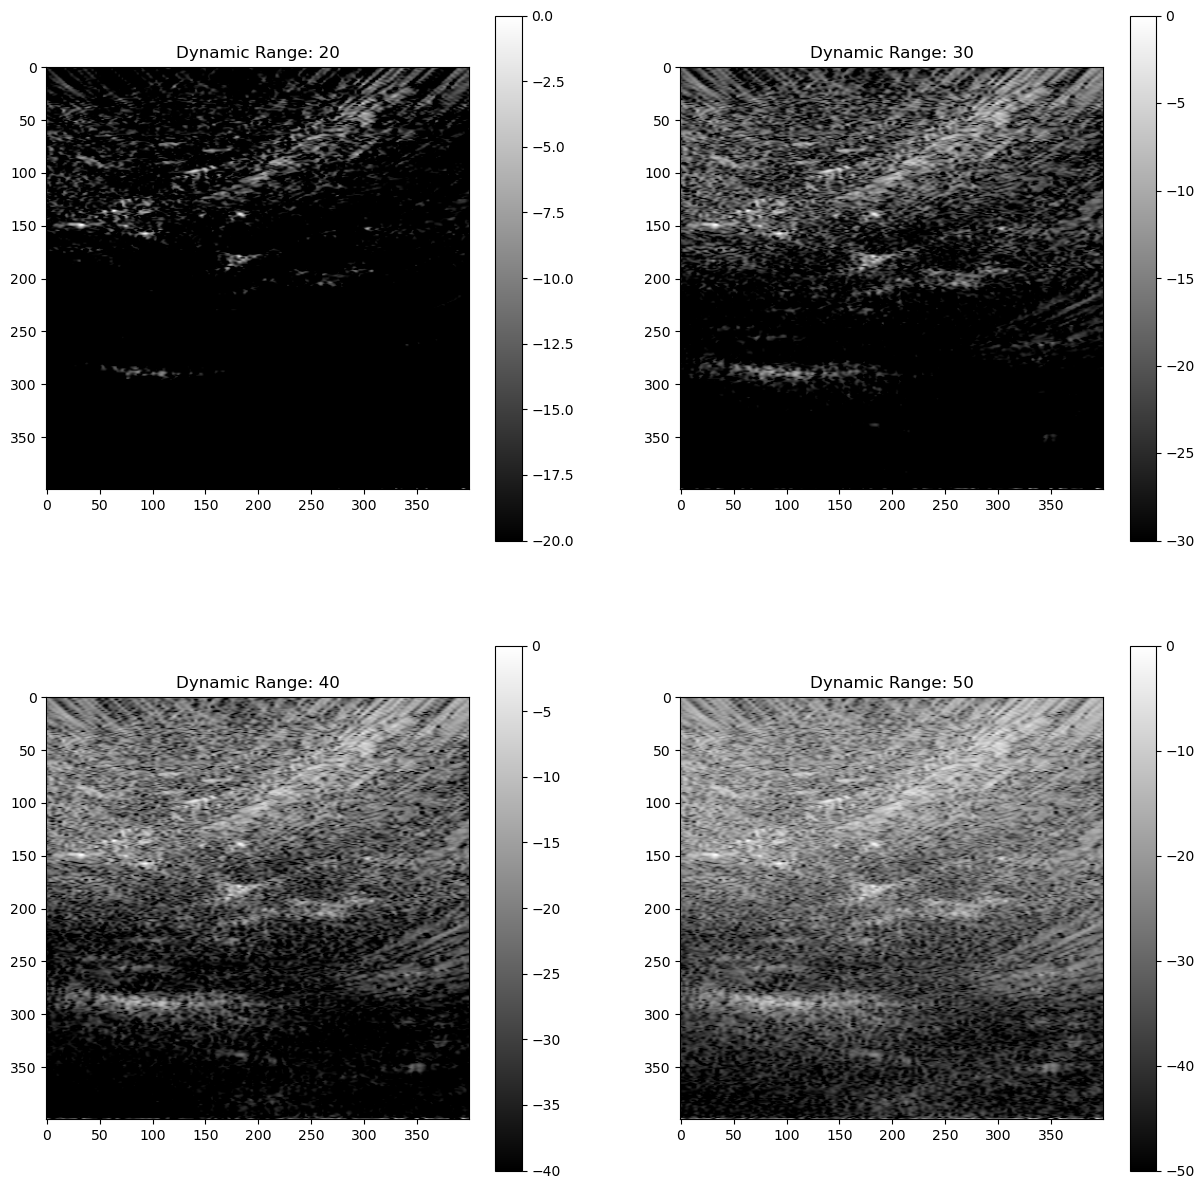

In [39]:
dynamic_range = [20, 30, 40, 50]
max_zero_img = scan_converted_image - np.max(scan_converted_image)
final_phantom_img = [np.maximum(max_zero_img, -dr) for dr in dynamic_range]

plt.figure(figsize=(15, 15))
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.imshow(final_phantom_img[i], cmap='gray')
    plt.title('Dynamic Range: ' + str(dynamic_range[i]))
    plt.colorbar()
plt.show()

# Generalization function

## Check the image

In [40]:
from pymatreader import read_mat
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage

def check_img(img_path, target_size=(400, 400)):
    def scan_convertion(image, target_size):
        return scipy.ndimage.zoom(image, (target_size[0] / image.shape[0], target_size[1] / image.shape[1]))
    img = read_mat(img_path)
    img = np.array(img['img'])
    converted_img = scan_convertion(img[:,:,0], target_size)
    plt.imshow(converted_img, cmap='gray')
    plt.colorbar()
    plt.show()


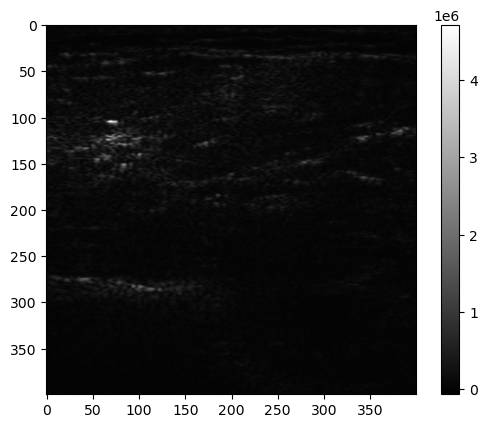

In [41]:
img_path = '202155642/arm_Img.mat'
check_img(img_path)

## rfdata processing

In [42]:
from scipy.signal import hilbert
import scipy.ndimage

def rfdata_to_img(rfdata_path, element=128, col_pixel=128, row_pixel=2048, col_spacing=0.3e-3, sound_speed=1540, sampling_rate=31.16e6, target_size=(400,400), dynamic_range=[20,30,40,50]):
    row_spacing = 0.04/row_pixel
    rfdata = read_mat(rfdata_path)
    rfdata = np.array(rfdata['rfdata'])
    distance = np.zeros((element, row_pixel, col_pixel))

    def cal_weight(p):
        i = int(p)
        f = p - i
        return (1-f, f)
    
    for ele in range(element):
        for row in range(row_pixel):
            if row == 0:
                distance[ele][row][ele] = row_spacing / 2
            else:
                distance[ele][row][ele] = distance[ele][row-1][ele] + row_spacing

    for ele in range(element):
        for row in range(row_pixel):
            for col in range(ele+1, col_pixel):
                distance[ele][row][col] = np.sqrt((np.abs(ele - col) * col_spacing)**2 + distance[ele][row][ele]**2)
            for col in range(ele-1, -1, -1):
                distance[ele][row][col] = np.sqrt((np.abs(ele - col) * col_spacing)**2 + distance[ele][row][ele]**2)

    delay = np.zeros((element, row_pixel, col_pixel))

    for ele in range(ele):
        for row in range(row_pixel):
            d = (row_spacing / 2) + (row * row_spacing)
            for col in range(col_pixel):
                l = distance[ele][row][col]
                delay[ele][row][col] = ((d + l) / sound_speed) * sampling_rate

    pixel = np.zeros((row_pixel, col_pixel))
    
    for row in range(row_pixel):
        for col in range(col_pixel):
            for ele in range(element):
                p = delay[ele][row][col]
                a, b = rfdata[:,:,0][int(p)][ele], rfdata[:,:,0][int(p) + 1][ele]
                a_w, b_w = cal_weight(p)
                pixel[row][col] += (a * a_w + b * b_w)
    
    pixel_hilbert = np.abs(hilbert(pixel, axis=0))
    log_pixel_hilbert = 20 * np.log10(pixel_hilbert)
    scan_converted_image = scan_convertion(log_pixel_hilbert, target_size)
    max_zero_img = scan_converted_image - np.max(scan_converted_image)
    final_phantom_img = [np.maximum(max_zero_img, -dr) for dr in dynamic_range]

    return final_phantom_img


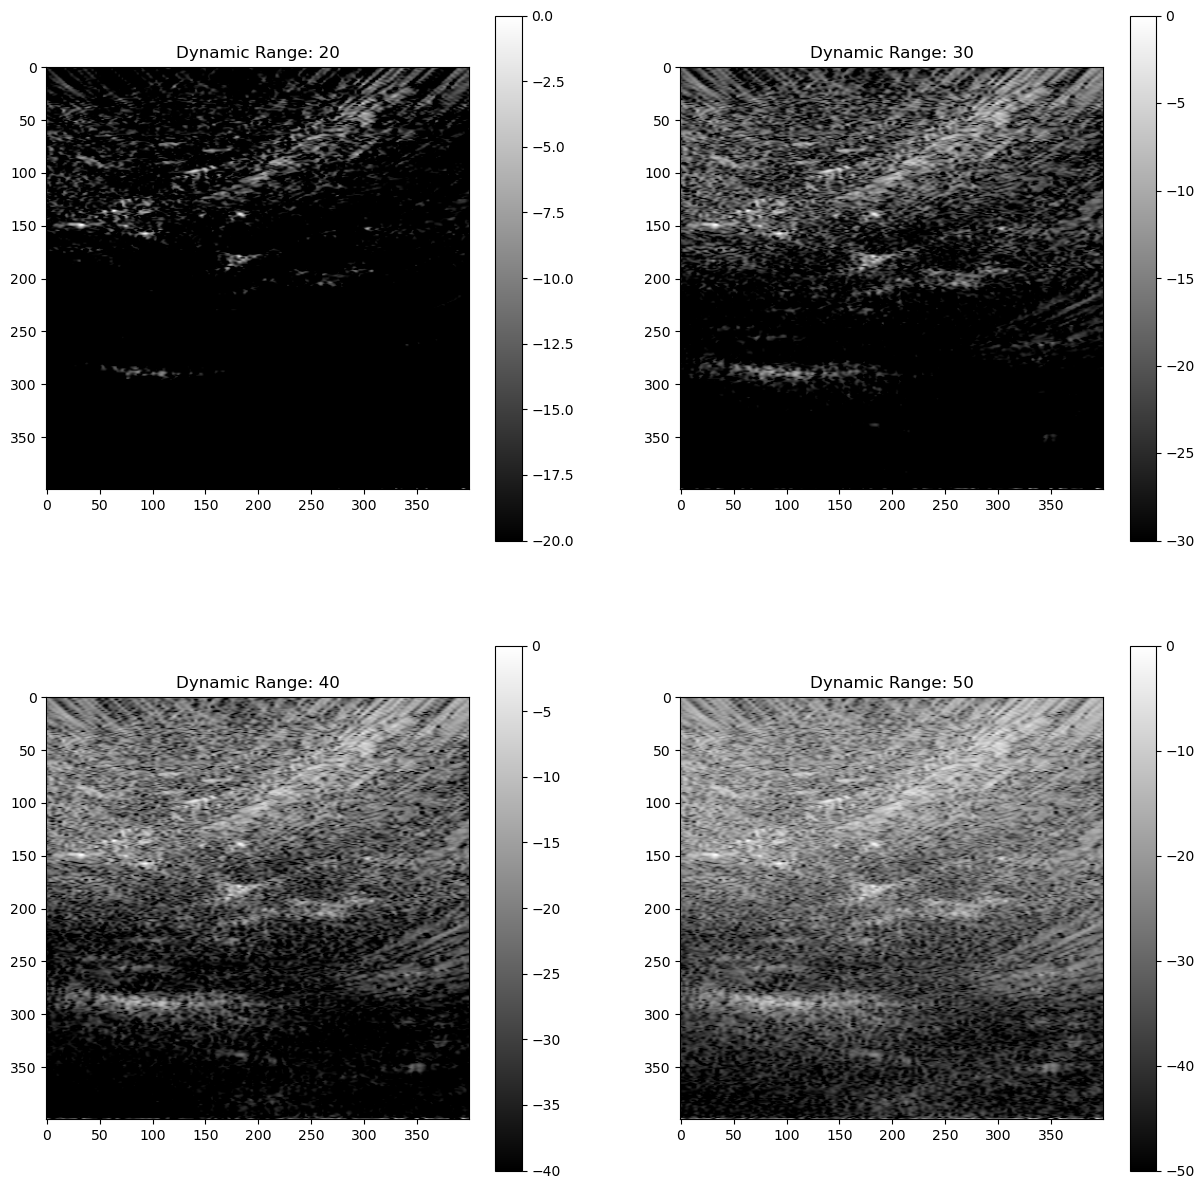

In [43]:
rf_data_path = '202155642/arm_rfdata.mat'
dynamic_range = [20, 30, 40, 50]
final_img = rfdata_to_img(rf_data_path, dynamic_range=dynamic_range)

plt.figure(figsize=(15, 15))
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.imshow(final_phantom_img[i], cmap='gray')
    plt.title('Dynamic Range: ' + str(dynamic_range[i]))
    plt.colorbar()
plt.show()

# mwkim data

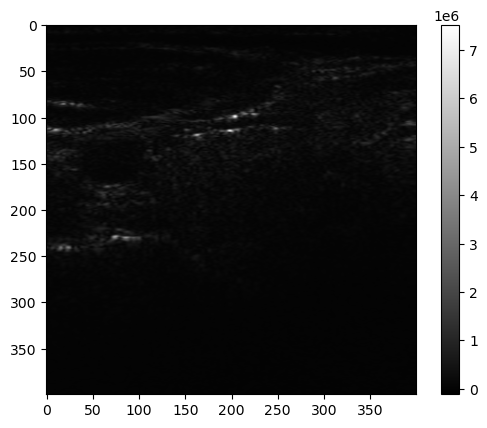

In [44]:
mwkim_img_path = 'mwkim/arm_Img.mat'

check_img(mwkim_img_path)

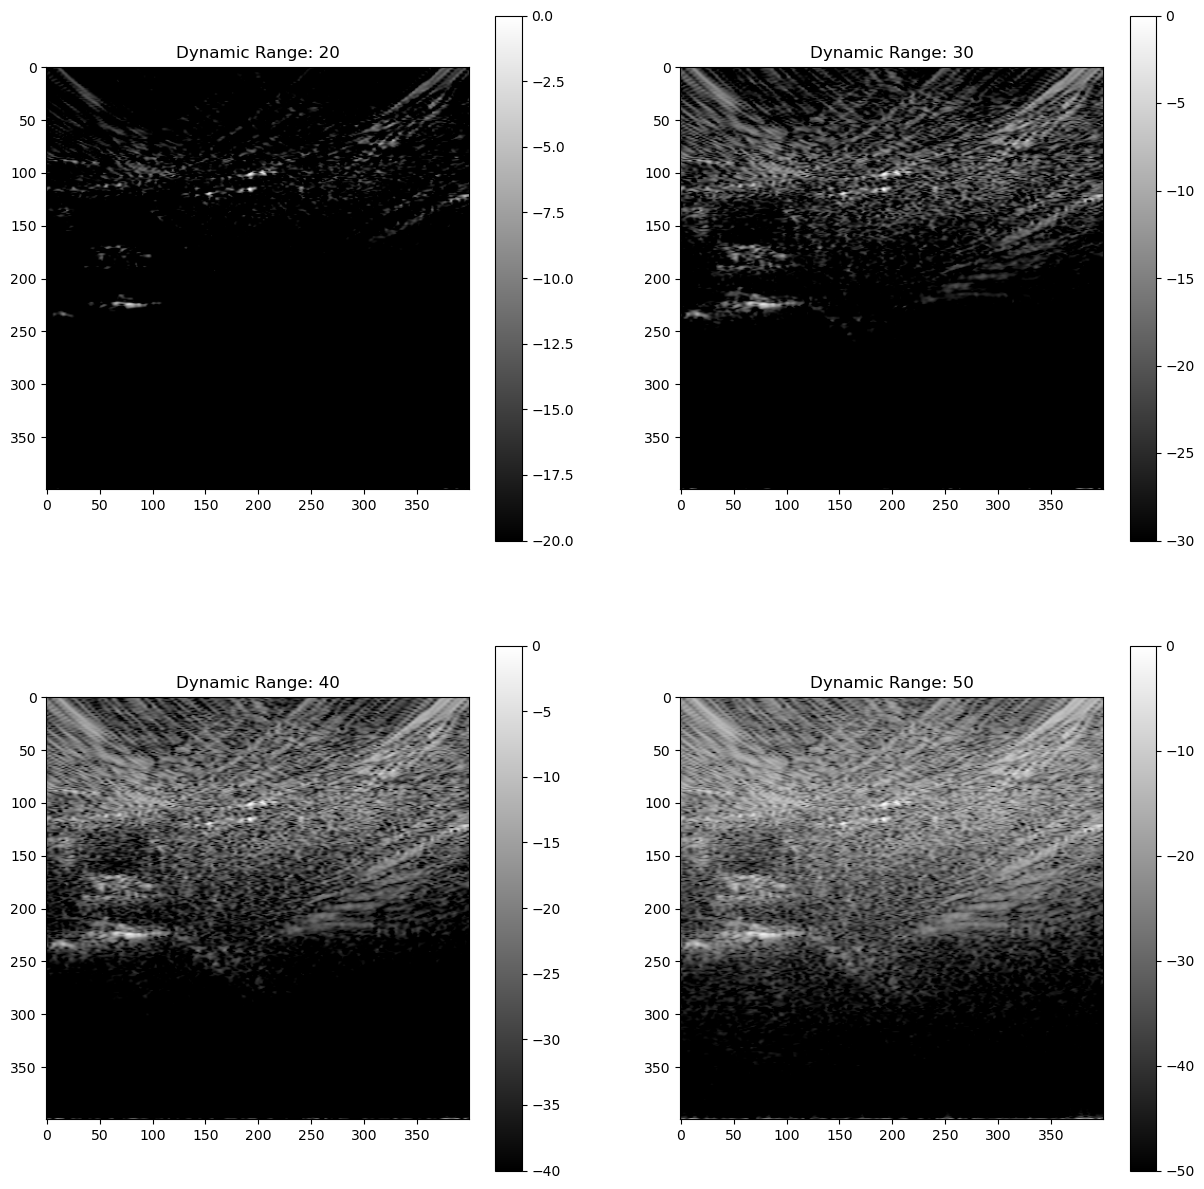

In [45]:
mwkim_rfdata_path = 'mwkim/arm_rfdata.mat'
sampling_rate = 7.6e6 * 4.1
dynamic_range = [20, 30, 40, 50]

mwkim_final_img = rfdata_to_img(mwkim_rfdata_path, dynamic_range=dynamic_range, sampling_rate=sampling_rate)

plt.figure(figsize=(15, 15))
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.imshow(mwkim_final_img[i], cmap='gray')
    plt.title('Dynamic Range: ' + str(dynamic_range[i]))
    plt.colorbar()
plt.show()